# The intent of this notebook is to familiarize ourselves with the data, do some exploratory analysis and to construct timeseries and other data for further analysis by the team

In [26]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import datetime
from mpl_toolkits.basemap import Basemap

import prep_data

# import findspark
# findspark.init()
# import pyspark
# sc = pyspark.SparkContext(appName="Spark1")

### Loading the data with some initial cleaning (h/t CS109Hubway for getting me started on this and for having the data loaded to github already)

In [2]:
stations_df = prep_data.stations('https://raw.githubusercontent.com/CS109Hubway/classp/master/data/hubway_stations.csv')
stations_df.head()

,id,terminal,station,municipal,lat,lng,status
0,3,B32006,Colleges of the Fenway,Boston,42.340021,-71.100812,Existing
1,4,C32000,Tremont St. at Berkeley St.,Boston,42.345392,-71.069616,Existing
2,5,B32012,Northeastern U / North Parking Lot,Boston,42.341814,-71.090179,Existing
3,6,D32000,Cambridge St. at Joy St.,Boston,42.361285,-71.065140,Existing
4,7,A32000,Fan Pier,Boston,42.353412,-71.044624,Existing


In [3]:
stations_df.shape

(142, 7)

In [4]:
trips_df = prep_data.trips('https://raw.githubusercontent.com/CS109Hubway/classp/master/data/tripsthrough2012.csv')
trips_df.head()

,index,seq_id,hubway_id,status,duration,start_date,strt_statn,end_date,end_statn,bike_nr,...,st_hour,end_hour,st_minute,end_minute,st_month,end_month,st_daydate,end_daydate,st_weekday,end_weekday
0,140521,140522,157655,Closed,189,2012-03-13 18:31:00,29.0,2012-03-13 18:34:00,18.0,B00094,...,18,18,1111,1114,3,3,2012-03-13,2012-03-13,1,1
1,140522,140524,157657,Closed,704,2012-03-15 00:00:00,40.0,2012-03-15 00:12:00,40.0,B00082,...,0,0,0,12,3,3,2012-03-15,2012-03-15,3,3
2,140523,140523,157656,Closed,1700,2012-03-15 00:00:00,7.0,2012-03-15 00:28:00,15.0,B00603,...,0,0,0,28,3,3,2012-03-15,2012-03-15,3,3
3,140524,140525,157658,Closed,1411,2012-03-15 00:00:00,41.0,2012-03-15 00:24:00,36.0,B00278,...,0,0,0,24,3,3,2012-03-15,2012-03-15,3,3
4,140525,140526,157659,Closed,251,2012-03-15 00:03:00,43.0,2012-03-15 00:07:00,40.0,B00076,...,0,0,3,7,3,3,2012-03-15,2012-03-15,3,3


In [5]:
weekdaystations = trips_df.loc[trips_df.st_weekday < 5]
weekdaystations.head()

,index,seq_id,hubway_id,status,duration,start_date,strt_statn,end_date,end_statn,bike_nr,...,st_hour,end_hour,st_minute,end_minute,st_month,end_month,st_daydate,end_daydate,st_weekday,end_weekday
0,140521,140522,157655,Closed,189,2012-03-13 18:31:00,29.0,2012-03-13 18:34:00,18.0,B00094,...,18,18,1111,1114,3,3,2012-03-13,2012-03-13,1,1
1,140522,140524,157657,Closed,704,2012-03-15 00:00:00,40.0,2012-03-15 00:12:00,40.0,B00082,...,0,0,0,12,3,3,2012-03-15,2012-03-15,3,3
2,140523,140523,157656,Closed,1700,2012-03-15 00:00:00,7.0,2012-03-15 00:28:00,15.0,B00603,...,0,0,0,28,3,3,2012-03-15,2012-03-15,3,3
3,140524,140525,157658,Closed,1411,2012-03-15 00:00:00,41.0,2012-03-15 00:24:00,36.0,B00278,...,0,0,0,24,3,3,2012-03-15,2012-03-15,3,3
4,140525,140526,157659,Closed,251,2012-03-15 00:03:00,43.0,2012-03-15 00:07:00,40.0,B00076,...,0,0,3,7,3,3,2012-03-15,2012-03-15,3,3


#### This is the beginning of our look at the top five connected stations in total, the results may change as we investigate this per hour

In [6]:
grouped_trips = weekdaystations.groupby(['strt_statn','end_statn'])
# grouped_trips.groups

In [7]:
bb = grouped_trips.seq_id.count()

In [8]:
cc = bb.values

In [9]:
dd = np.argsort(cc)[::-1]

In [10]:
bb[dd[:5]]

strt_statn  end_statn
22.0        38.0         1888
40.0        22.0         1704
38.0        22.0         1685
22.0        40.0         1624
            43.0         1226
Name: seq_id, dtype: int64

In [11]:
print bb[dd[:5]].index[0]

(22.0, 38.0)


## What I want to find
* Time series for each station, cumulative sum sorted by timestamp (**done 27 April**)
* Take aways and returns for each station per hour (for animation) 
    * Might want to gather top 5 paired stations per hour (*started 27 April*)
    * will also help for GP interrogation of intensity surface
* 

### Timeseries...
We need to group by station (both as origin and ending) and sort by timestamp +1s for outgoing bikes and -1s for incoming bikes (there needs to be a unified timestamp domain for the sake of consistency between stations)

I decided to gather two timeseries at different frequencies of time. The first is for every hour from March to November 2012. The second is for every day from March to November 2012

In [12]:
day_set = set(trips_df.st_daydate.tolist())
day_set |= set(trips_df.end_daydate.tolist())
day_set = list(day_set)

In [13]:
timeseries_matrix_day = np.zeros((len(stations_df),len(day_set)))
timeseries_matrix_hour = np.zeros((len(stations_df),len(day_set)*len(np.unique(trips_df.st_hour))))

In [14]:
print timeseries_matrix_day.shape
print timeseries_matrix_hour.shape

(142, 261)
(142, 6264)


In [15]:
for row in trips_df.iterrows():
#     print row[1][6], row[1][8], row[1][8]==row[1][8]
    if row[1][6] != row[1][6]:
        continue
    st_station_idx = int(row[1][6] - 3)
    st_day = day_set.index(row[1][20])
    st_idx = int(24*st_day + row[1][14])
    if row[1][8] != row[1][8]:
        continue
    end_station_idx = int(row[1][8] - 3)
    end_day = day_set.index(row[1][21])
    end_idx = int(24*end_day + row[1][15])
    
    timeseries_matrix_hour[st_station_idx,st_idx] += 1
    timeseries_matrix_hour[end_station_idx,end_idx] -= 1
    
    timeseries_matrix_day[st_station_idx,st_day] += 1
    timeseries_matrix_day[end_station_idx,end_day] -= 1
    

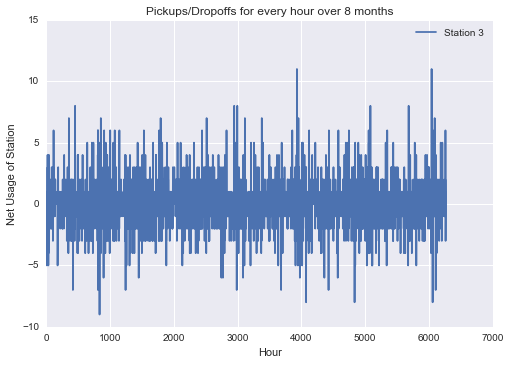

In [16]:
plt.figure()
plt.plot(timeseries_matrix_hour[0,:],label="Station 3")
plt.title("Pickups/Dropoffs for every hour over 8 months")
plt.xlabel("Hour")
plt.ylabel("Net Usage of Station")
plt.legend()
plt.show()

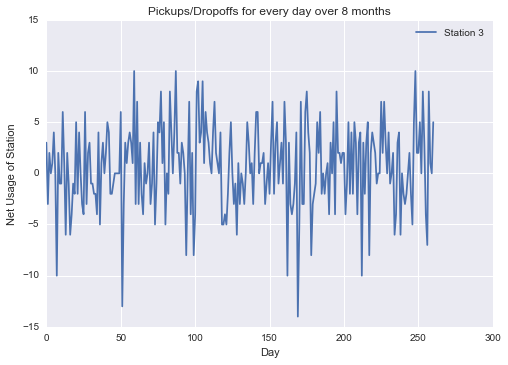

In [17]:
plt.figure()
plt.plot(timeseries_matrix_day[0,:],label='Station 3')
plt.title("Pickups/Dropoffs for every day over 8 months")
plt.xlabel("Day")
plt.ylabel("Net Usage of Station")
plt.ylim([-15,15])
plt.legend()
plt.show()

In [27]:
with open("timeseries_hourly.npy",'w') as hr:
    pickle.dump(timeseries_matrix_hour,hr)

with open("timeseries_daily.npy",'w') as da:
    pickle.dump(timeseries_matrix_day,da)

### Here's an example of using the discrete minute/second time of every pickup and drop off for Station 3
(I quickly noticed that this was certainly not the right way to go about this... I switched to the less efficient but more cautious method above)

In [18]:
# Get unique domain for all possible times.
time_domain = set()
time_domain |= set(trips_df.start_date.tolist())
time_domain |= set(trips_df.end_date.tolist())
time_domain = sorted(list(time_domain))

In [19]:
station_timeseries = np.zeros(len(time_domain))

In [20]:
station3 = weekdaystations.loc[weekdaystations.strt_statn==3]
station3_start_times = station3.start_date.tolist()
station3_end_times = station3.end_date.tolist()

In [21]:
take_idx = [time_domain.index(time) for time in station3_start_times]
return_idx = [time_domain.index(time) for time in station3_end_times]

In [22]:
for ii in take_idx:
    station_timeseries[ii] += 1
for jj in return_idx:
    station_timeseries[jj] -= 1

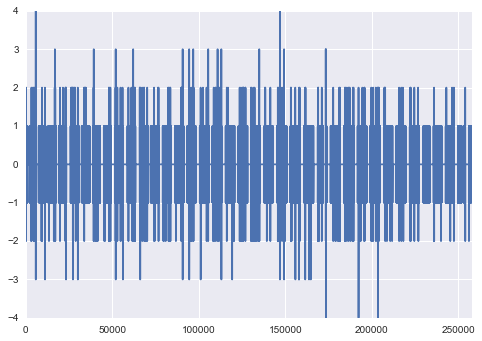

In [23]:
plt.figure()
plt.plot(station_timeseries)
plt.xlim([0,len(station_timeseries)])
plt.show()

In [24]:
station4 = weekdaystations.loc[weekdaystations.strt_statn==4]
station4_start_times = station4.start_date.tolist()
station4_end_times = station4.end_date.tolist()

In [25]:
take_idx4 = [time_domain.index(time)]